# 1. Webscraping
Using Python API to collect posts and comments from specific subreddits.

### 1.1 Educators
Subreddit: 'r/AskProfessors', 'r/highereducation', 'r/Professors'

In [20]:
import praw
import csv
import datetime
import prawcore
import time
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from nltk.corpus import stopwords
import re
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaMulticore
import pickle
import os
import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from collections import defaultdict
import subprocess
from scipy.stats import f_oneway

In [21]:
personal_info = pd.read_csv('personal_info.csv')
reddit = praw.Reddit(client_id=personal_info.iloc[:, 1][0],
                     client_secret=personal_info.iloc[:, 1][1],
                     user_agent=personal_info.iloc[:, 1][2],
                     username=personal_info.iloc[:, 1][3],
                     password=personal_info.iloc[:, 1][4]
)

# Subreddits: r/AskProfessors, r/highereducation, r/Professors
subreddits = ['AskProfessors', 'highereducation', 'Professors']

with open('teachers_posts.csv', 'w', newline='', encoding='utf-8') as post_file, \
     open('teachers_comments.csv', 'w', newline='', encoding='utf-8') as comment_file:
    # write a csv file to store data
    csv_post = csv.writer(post_file)
    csv_comment = csv.writer(comment_file)
    # write table headers
    csv_post.writerow(['Subreddit', 'Title', 'Body', 'ID', 'Timestamp', 'Author', 'Votes', 'Num Comments'])
    csv_comment.writerow(['Subreddit', 'Post ID', 'Comment ID', 'Comment Body', 'Timestamp', 'Votes'])

    for sub in subreddits:
        print(f"Searching in subreddit: {sub}")
        subreddit = reddit.subreddit(sub)
        keywords = ['ChatGPT', 'AI generated', 'using AI', 'AI written', 'Chatbot',
                    'ChatGPT in education', 'AI in education', 'AI for studying',
                    'ChatGPT study aid', 'AI in university', 'GPT for learning']
        for keyword in keywords:
            print(f"Using keyword: {keyword}")
            try:
                for submission in subreddit.search(keyword, limit=None):
                    # Convert time format
                    post_timestap = datetime.datetime.fromtimestamp(submission.created_utc).isoformat()
                    # Collect post details
                    
                    post_details = [sub, submission.title, submission.selftext, submission.id, post_timestap, 
                                    submission.author.name if submission.author else 'N/A', 
                                    submission.score, submission.num_comments]
                    csv_post.writerow(post_details)

                    # Collect all comments
                    submission.comments.replace_more(limit=None)
                    for comment in submission.comments.list():
                        # Comment details
                        comment_timestamp = datetime.datetime.fromtimestamp(comment.created_utc).isoformat()
                        comment_details = [sub, submission.id, comment.id, comment.body, 
                                            comment_timestamp, comment.score]
                        csv_comment.writerow(comment_details)
            except prawcore.exceptions.TooManyRequests as e:
                print('Request frequency limit reached, pause for a while...')
                time.sleep(60)  # Pause for 60s

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3584343020.py, line 4)

### 1.2 Students
Subreddit: 'r/college', 'r/GradSchool' and 'r/CollegeRant'

In [ ]:
# Subreddits: r/college, r/GradSchool and r/CollegeRant
subreddits = ['r/college', 'r/GradSchool', 'r/CollegeRant']

with open('teachers_posts.csv', 'w', newline='', encoding='utf-8') as post_file, \
     open('teachers_comments.csv', 'w', newline='', encoding='utf-8') as comment_file:
    # write a csv file to store data
    csv_post = csv.writer(post_file)
    csv_comment = csv.writer(comment_file)
    # write table headers
    csv_post.writerow(['Subreddit', 'Title', 'Body', 'ID', 'Timestamp', 'Author', 'Votes', 'Num Comments'])
    csv_comment.writerow(['Subreddit', 'Post ID', 'Comment ID', 'Comment Body', 'Timestamp', 'Votes'])

    for sub in subreddits:
        print(f"Searching in subreddit: {sub}")
        subreddit = reddit.subreddit(sub)
        keywords = ['ChatGPT', 'AI generated', 'using AI', 'AI written', 'Chatbot',
                    'ChatGPT in education', 'AI in education', 'AI for studying',
                    'ChatGPT study aid', 'AI in university', 'GPT for learning']
        for keyword in keywords:
            print(f"Using keyword: {keyword}")
            try:
                for submission in subreddit.search(keyword, limit=None):
                    # Convert time format
                    post_timestap = datetime.datetime.fromtimestamp(submission.created_utc).isoformat()
                    # Collect post details
                    
                    post_details = [sub, submission.title, submission.selftext, submission.id, post_timestap, 
                                    submission.author.name if submission.author else 'N/A', 
                                    submission.score, submission.num_comments]
                    csv_post.writerow(post_details)

                    # Collect all comments
                    submission.comments.replace_more(limit=None)
                    for comment in submission.comments.list():
                        # Comment details
                        comment_timestamp = datetime.datetime.fromtimestamp(comment.created_utc).isoformat()
                        comment_details = [sub, submission.id, comment.id, comment.body, 
                                            comment_timestamp, comment.score]
                        csv_comment.writerow(comment_details)
            except prawcore.exceptions.TooManyRequests as e:
                print('Request frequency limit reached, pause for a while...')
                time.sleep(60)  # Pause for 60s

# 2. Reading Data Files

In [1]:
def read_file(csv_file):
    df = pd.read_csv(csv_file, encoding='ISO-8859-1') # Subreddit, Title, Body ID, Timestamp, Author, Votes, Num Comments
    return df

post_student_df = read_file('students_posts.csv')
comment_student_df = read_file('students_comments.csv')
post_teacher_df = read_file('teachers_posts.csv')
comment_teacher_df = read_file('teachers_comments.csv')

# 3. Data Clean (initially)

In [2]:
# Check missing values
def mv(df):
    mv = df.isnull().sum()
    return mv

mv_student_post = mv(post_student_df)
mv_student_comment = mv(comment_student_df)
mv_teacher_post = mv(post_teacher_df)
mv_teacher_comment = mv(comment_teacher_df)
mv_teacher_comment

Subreddit       0
Post ID         0
Comment ID      0
Comment Body    5
Timestamp       0
Votes           0
dtype: int64

In [3]:
def time_convert(df, subset_columns=None):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Filter date
    df = df.loc[(df['Timestamp'] >= pd.to_datetime('2022-11-1')) & 
                (df['Timestamp'] <= pd.to_datetime('2024-2-1'))]

    # Delete duplicated rows if subset_columns is provided and exists in DataFrame
    if subset_columns and all(col in df.columns for col in subset_columns):
        df = df.drop_duplicates(subset=subset_columns, keep='first').copy()
    return df

post_student_df = time_convert(post_student_df, subset_columns=['Title', 'Body'])
post_teacher_df = time_convert(post_teacher_df, subset_columns=['Title', 'Body'])

comment_student_df = time_convert(comment_student_df, subset_columns=['Comment ID'])
comment_teacher_df = time_convert(comment_teacher_df, subset_columns=['Comment ID'])
comment_student_df # 12835
comment_teacher_df # 17803

,Subreddit,Post ID,Comment ID,Comment Body,Timestamp,Votes
0,AskProfessors,18vniv3,kijrvt5,Your question looks like it may be answered by...,2024-01-19 06:17:06,1
1,AskProfessors,18vniv3,kftwg1j,Appeal your grade next semester if you believe...,2024-01-01 14:31:10,38
2,AskProfessors,18vniv3,kfugp2q,If you can show other work written for the cou...,2024-01-01 17:14:11,33
3,AskProfessors,18vniv3,kftwfyc,If you didnât use AI then contest your grade...,2024-01-01 14:31:09,108
4,AskProfessors,18vniv3,kfuhol4,Just Google your school name and the words â...,2024-01-01 17:20:48,9
...,...,...,...,...,...,...
39705,Professors,14676su,jnpd5et,Except that Lovecraft himself didnât believe...,2023-06-10 23:16:04,4
39706,Professors,14676su,jnu3fua,"In the lidless, soulless, reptilian eyes of ad...",2023-06-12 00:37:12,3
39707,Professors,14676su,jns4go7,Spent most his career being super racist and n...,2023-06-11 16:04:32,3
39708,Professors,14676su,jns69lt,Also true,2023-06-11 16:18:41,3


In [4]:
# Define a function to delete url and robots
def remove_urls(text):
    url_pattern = r'https?://\S+|www\.\S+|(\[.*?\]\(http[s]?://.*?\))|(<a href=".*?">.*?</a>)'
    return re.sub(url_pattern, '', text)

def is_bot_comment(comment):
    bot_phrases = [
        "I am a bot", 
        "this action was performed automatically", 
        "please contact the moderators",
    ]
    return any(phrase in comment for phrase in bot_phrases)

In [7]:
# Define a function to filter comments that do not contain specific keywords
keywords = ['ChatGPT', 'AI generated', 'using AI', 'AI written', 
            'ChatGPT in education', 'Artificial Intelligence', 
            'GPT', 'Chatbot', 'cheat', 'accuse', 'OpenAI',
            'academic integrity', 'plagiarism detection', 'AI tutor',
            'concern', 'excited about', 'worry', 'ethical concerns',
            'students', 'professors', 'paper', 'school', 'class',
            'remote learning', 'digital tools in education', 'learning efficiency'
]

def contains_keyword(comment):
    if not isinstance(comment, str):
        return False  # Return False immediately if not a string
    cleaned_comment = remove_urls(comment) # Remove URLs from the comment
    cleaned_comment = cleaned_comment.lower() # Convert comment to lowercase
    # Check if any keyword is in the comment and that it is not from a bot
    return any(word.lower() in cleaned_comment for word in keywords) and not is_bot_comment(cleaned_comment)

# Apply the function to filter DataFrame
comment_student_df.loc[:, 'is_relevant'] = comment_student_df['Comment Body'].apply(contains_keyword)
comment_teacher_df.loc[:, 'is_relevant'] = comment_teacher_df['Comment Body'].apply(contains_keyword)

# Only retain rows that contain keywords and are not bot comments
comment_student_df = comment_student_df[comment_student_df['is_relevant']]
comment_teacher_df = comment_teacher_df[comment_teacher_df['is_relevant']]
comment_student_df # 5575
comment_teacher_df # 8527

,Subreddit,Post ID,Comment ID,Comment Body,Timestamp,Votes,is_relevant
2,AskProfessors,18vniv3,kfugp2q,If you can show other work written for the cou...,2024-01-01 17:14:11,33,True
3,AskProfessors,18vniv3,kftwfyc,If you didnât use AI then contest your grade...,2024-01-01 14:31:09,108,True
4,AskProfessors,18vniv3,kfuhol4,Just Google your school name and the words â...,2024-01-01 17:20:48,9,True
5,AskProfessors,18vniv3,kftzwfk,Contest your grade. File a grievance. Go to ...,2024-01-01 15:04:02,28,True
8,AskProfessors,18vniv3,kfvruz0,This is a bummer. Please know that this stuff ...,2024-01-01 22:00:32,3,True
...,...,...,...,...,...,...,...
39434,Professors,157oi39,jt65a5v,I worried about that when I first did the quiz...,2023-07-23 23:20:03,0,True
39435,Professors,157oi39,jt64alk,I had students in the US and China during the ...,2023-07-23 23:12:57,2,True
39436,Professors,157oi39,jt7gdlo,"I read that, but thatâs a pretty big obstacl...",2023-07-24 05:39:07,-3,True
39438,Professors,157oi39,jt64ipq,And no one complained about the time limited q...,2023-07-23 23:14:34,1,True


In [8]:
# filter short and low content comments
def filter_short_and_low_content_comments(comment, min_words=10):
    words = comment.split()
    
    if len(words) < min_words:
        return False
    
    # if sentence only contains repeated words
    if len(set(words)) < min_words / 2:
        return False

    return True

comment_student_df = comment_student_df[comment_student_df['Comment Body'].apply(filter_short_and_low_content_comments)]
comment_teacher_df = comment_teacher_df[comment_teacher_df['Comment Body'].apply(filter_short_and_low_content_comments)]

comment_student_df # number of comments: 5562
comment_teacher_df # number of comments: 8296

,Subreddit,Post ID,Comment ID,Comment Body,Timestamp,Votes,is_relevant
2,AskProfessors,18vniv3,kfugp2q,If you can show other work written for the cou...,2024-01-01 17:14:11,33,True
3,AskProfessors,18vniv3,kftwfyc,If you didnât use AI then contest your grade...,2024-01-01 14:31:09,108,True
4,AskProfessors,18vniv3,kfuhol4,Just Google your school name and the words â...,2024-01-01 17:20:48,9,True
5,AskProfessors,18vniv3,kftzwfk,Contest your grade. File a grievance. Go to ...,2024-01-01 15:04:02,28,True
8,AskProfessors,18vniv3,kfvruz0,This is a bummer. Please know that this stuff ...,2024-01-01 22:00:32,3,True
...,...,...,...,...,...,...,...
39434,Professors,157oi39,jt65a5v,I worried about that when I first did the quiz...,2023-07-23 23:20:03,0,True
39435,Professors,157oi39,jt64alk,I had students in the US and China during the ...,2023-07-23 23:12:57,2,True
39436,Professors,157oi39,jt7gdlo,"I read that, but thatâs a pretty big obstacl...",2023-07-24 05:39:07,-3,True
39438,Professors,157oi39,jt64ipq,And no one complained about the time limited q...,2023-07-23 23:14:34,1,True


# 4. Data Description and Visualization

First, we count the number of posts and comments in total. Then we count how many posts and comments per subreddit and make comparison. The data are from the three subreddits (r/college, r/Gradschool, r/CollegeRant).

The Number of Total Teacher Posts: 600
The Number of Total Teacher Comments: 8296


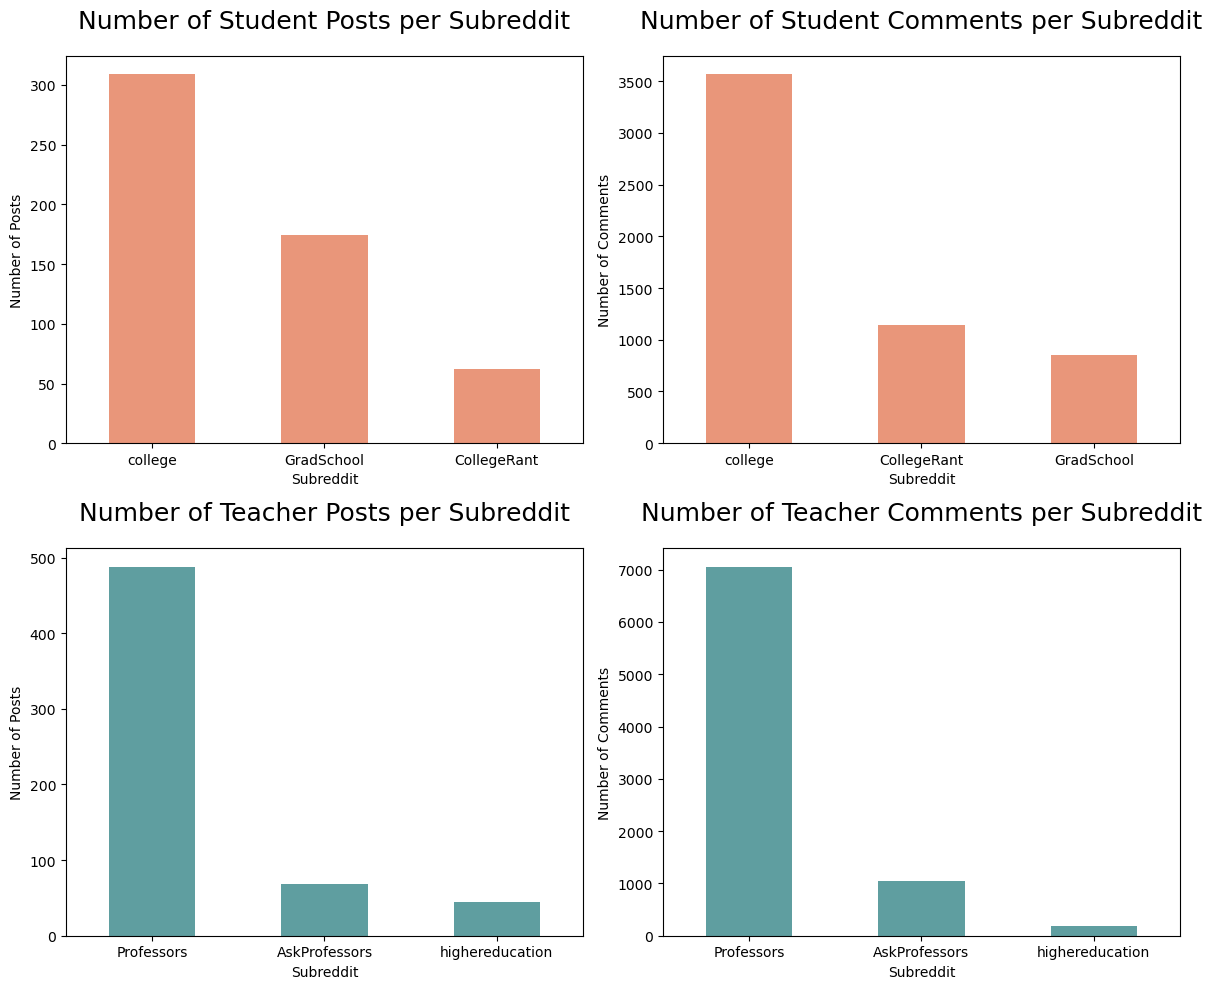

In [7]:
# Counts of posts and comments per subreddit
# student
post_student_counts = post_student_df['Subreddit'].value_counts()
comment_student_counts = comment_student_df['Subreddit'].value_counts()
# teacher
post_teacher_counts = post_teacher_df['Subreddit'].value_counts()
comment_teacher_counts = comment_teacher_df['Subreddit'].value_counts()

print('The Number of Total Teacher Posts:', len(post_teacher_df))
print('The Number of Total Teacher Comments:', len(comment_teacher_df))

# Create a 2x2 subplot layout
plt.figure(figsize=(12, 10))

# First subplot: Number of student posts per subreddit
plt.subplot(2, 2, 1)  # (rows, columns, subplot number)
post_student_counts.plot(kind='bar', color='darksalmon')
plt.title('Number of Student Posts per Subreddit', fontsize=18, pad=20)
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts')
plt.xticks(rotation=0)  # Adjust rotation for readability

# Second subplot: Number of teacher posts per subreddit
plt.subplot(2, 2, 3)
post_teacher_counts.plot(kind='bar', color='cadetblue')
plt.title('Number of Teacher Posts per Subreddit', fontsize=18, pad=20)
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts')
plt.xticks(rotation=0)

# Third subplot: Number of student comments per subreddit
plt.subplot(2, 2, 2)
comment_student_counts.plot(kind='bar', color='darksalmon')
plt.title('Number of Student Comments per Subreddit', fontsize=18, pad=20)
plt.xlabel('Subreddit')
plt.ylabel('Number of Comments')
plt.xticks(rotation=0)

# Fourth subplot: Number of teacher comments per subreddit
plt.subplot(2, 2, 4)
comment_teacher_counts.plot(kind='bar', color='cadetblue')
plt.title('Number of Teacher Comments per Subreddit', fontsize=18, pad=20)
plt.xlabel('Subreddit')
plt.ylabel('Number of Comments')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

We sort the posts and comments by date, and then plot the daily count of posts and comments over time to visually analyze their trends.

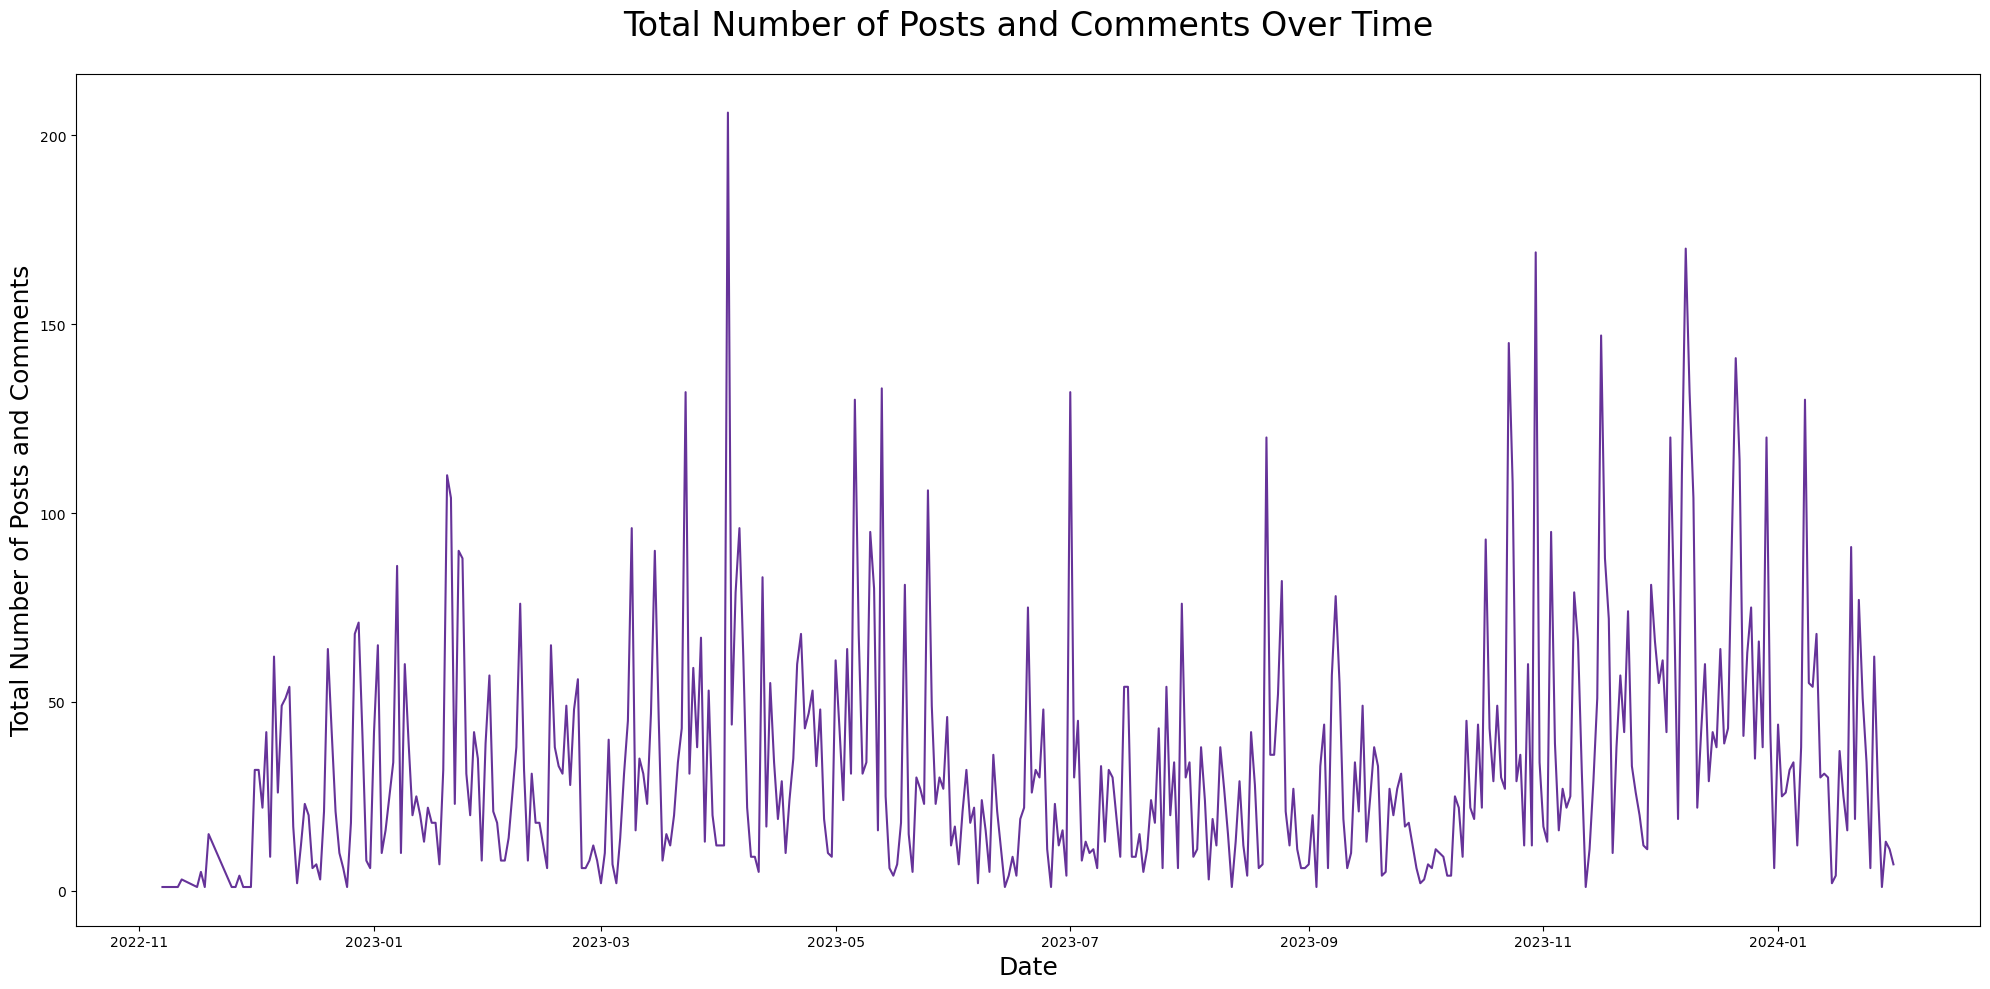

In [69]:
# Group and count student posts and comments by date
student_posts_count_by_date = post_student_df.groupby(post_student_df['Timestamp'].dt.date).size()
student_comments_count_by_date = comment_student_df.groupby(comment_student_df['Timestamp'].dt.date).size()

# Group and count teacher posts and comments by date
teacher_posts_count_by_date = post_teacher_df.groupby(post_teacher_df['Timestamp'].dt.date).size()
teacher_comments_count_by_date = comment_teacher_df.groupby(comment_teacher_df['Timestamp'].dt.date).size()

# Combine student and teacher counts
combined_counts_by_date = student_posts_count_by_date.add(student_comments_count_by_date, fill_value=0) \
    .add(teacher_posts_count_by_date, fill_value=0) \
    .add(teacher_comments_count_by_date, fill_value=0)

# Plot the combined counts
plt.figure(figsize=(20, 10))
combined_counts_by_date.plot(color='rebeccapurple')
plt.title('Total Number of Posts and Comments Over Time', fontsize=24, pad=28)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Total Number of Posts and Comments', fontsize=18)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Top 10 posts with the most comments

In [20]:
post_teacher_df.sort_values(by='Num Comments', ascending=False).head(10)

,Subreddit,Title,Body,ID,Timestamp,Author,Votes,Num Comments
750,Professors,Students are cheating with AI because you have...,You can no longer assign essays to be complete...,17jmxja,2023-10-30 07:15:37,OsakaWilson,385,277
36,AskProfessors,Why Do You Hate Accommodations?,I was scrolling through r/professors when I sa...,191nvs3,2024-01-08 16:35:31,ceratops1312,0,270
481,Professors,"Article: ""I'm a student. You have no idea how ...",Exactly what I wanted to see after catching ha...,13g5quq,2023-05-13 05:19:39,SailorKlingon,394,246
1239,Professors,Student missed final exam and decided to beg &...,"For context, my university does final exams at...",18ei4a7,2023-12-09 18:12:42,radicallkaticall,454,231
888,Professors,Students won't buy textbooks for class,I'm at an urban R2 where the socioeconomic sta...,17wmjfb,2023-11-16 14:12:18,ProfessorJAM,146,179
344,Professors,Harvard '21 grad says Gen Z just uses A.I. to ...,"\n\n""An exchange between an enterprising recen...",150fbn6,2023-07-15 17:47:05,PlasticBlitzen,301,171
565,Professors,Back to multiple choice exams,I'm so tired of reading AI-generated garbage t...,17e5yso,2023-10-23 01:05:31,CyberJay7,477,167
19,AskProfessors,am I too cynical?,Here are three thoughts from all the questions...,18mb3gb,2023-12-19 21:05:55,SnooCats6706,86,167
311,Professors,Just Failed 15 students for cheating with ChatGPT,Instructor at an R1 STEM grad program in the U...,11z7fme,2023-03-23 04:34:11,Smooth-Earth-9897,943,167
310,Professors,"Typical words ""utilized"" by ChatGPT",I am wondering if there are any specific words...,18nmf24,2023-12-21 13:55:56,MonkZer0,125,159


Top 10 Posts with the most votes

In [87]:
post_teacher_df.sort_values(by='Votes', ascending=False).head(10)

,Subreddit,Title,Body,ID,Timestamp,Author,Votes,Num Comments
317,Professors,"Thankfully, we have a method of identifying es...",NaN,12twadi,2023-04-21 11:39:56,ConceptOfHangxiety,1399,86
1168,Professors,"16 years at my university, thought Iâd seen ...","Student (donât know if he was mine or not, c...",zhujdo,2022-12-10 15:57:34,elperro,1051,82
1275,Professors,interesting use of chatgpt in a class and resu...,NaN,146z52l,2023-06-11 19:03:44,Cherveny2,1034,43
341,Professors,Drew this after a week of inner turmoil about ...,NaN,107eme3,2023-01-09 14:38:37,TheLifeAdjunct,1007,148
311,Professors,Just Failed 15 students for cheating with ChatGPT,Instructor at an R1 STEM grad program in the U...,11z7fme,2023-03-23 04:34:11,Smooth-Earth-9897,943,167
579,Professors,"my class is doomed, my field is doomed, and my...",I teach in computer science. My students have ...,1609xey,2023-08-24 20:24:48,scaryrodent,805,156
571,Professors,"Professor LPT: Use the words ""in your opinion""...",My friend sent me this. A student in their onl...,11mayuu,2023-03-08 23:54:14,UniversityUnlikely22,770,61
1167,Professors,Post-grading flu is real.,NaN,zq03y3,2022-12-19 19:54:24,casseroleplay,699,83
482,Professors,Chat GPT just wrote me a 60-question multiple-...,I of course had to edit questions and answer c...,14g67vw,2023-06-22 17:15:31,Nerobus,695,97
1045,Professors,"...okay, but that's worse. You do get how that...","Some of my students had a low stakes, online q...",10x5toh,2023-02-08 18:49:49,VenusSmurf,646,66


Top 10 Comments with the most votes

In [88]:
comment_teacher_df.sort_values(by='Votes', ascending=False).head(10)

,Subreddit,Post ID,Comment ID,Comment Body,Timestamp,Votes,is_relevant
13843,Professors,11mayuu,jbgyiv4,I had this happen today with a student leaving...,2023-03-09 00:35:44,535,True
5841,Professors,11z7fme,jdbix35,"Honestly, fake citations alone is an academic ...",2023-03-23 06:16:17,484,True
6456,Professors,12twadi,jh4rebj,Why do they get to rewrite it? Shouldn't they ...,2023-04-21 13:33:54,449,True
12820,Professors,zbmu8y,iys213x,This was the sentence that made me immediately...,2022-12-03 19:47:35,449,True
8568,Professors,12a0qpu,jepzzps,ChatGPT doesn't keep a record of what it gener...,2023-04-03 01:34:19,417,True
10980,Professors,13g5quq,jjyy3ay,"Yeah, a colleague recently put it as, ""There a...",2023-05-13 08:19:36,408,True
18883,Professors,17jmxja,k72oljq,How do I apply your advice to 275 students in ...,2023-10-30 12:14:34,394,True
34874,Professors,zhujdo,izo3ep1,I once had a student from another section of t...,2022-12-10 16:49:04,381,True
11731,Professors,15i4azl,jus2ey9,Does your university have no academic integrit...,2023-08-04 18:24:53,374,True
14256,Professors,12bl3kf,jexbskw,None of the AI detectors are reliable and its ...,2023-04-04 17:02:04,358,True


# 5. Topic Modeling

### 5.1 Data Pre-processing (For Topic Modeling)

In order to conduct topic modelling, we need make tokenization as pre-processing step first. Tokenize, lemmatize the comments, remove useless words.

In [9]:
nlp = spacy.load('en_core_web_sm', 
                 disable=['parser', 'ner']) # to improve efficiency of codes

stop_words = set(stopwords.words('english'))
additional_stopwords = {"'m", "'re", "'ve", "'d", "'ll", "'s", "from", "subject", 
                        "class", "can", "could", "use", "make", "get", "go",
                        "get", "like", "thing", "well", "really", "might", "even", "much",
                        "something", "someone", "know", "want", "need", "try", "would", "should"}
stop_words.update(additional_stopwords)

def preprocess_text(text):
    # Tokenize and lemmatize text
    doc = nlp(text)
    # Remove non-alphabetic words and stopwords
    # Lowercase characters
    processed_tokens = [token.lemma_.lower() for token in doc if token.is_alpha and token.lemma_.lower() not in stop_words]
    return ' '.join(processed_tokens)

# Define a function to generate corpus
def tokenized_corpus(comments):
    processed_corpus = [preprocess_text(text) for text in comments]
    tokenized_corpus = [doc.split() for doc in processed_corpus]
    return tokenized_corpus

# Tokenize the student and teacher comments
student_corpus_tokenized = tokenized_corpus(comment_student_df['Comment Body'].tolist())
teacher_corpus_tokenized = tokenized_corpus(comment_teacher_df['Comment Body'].tolist())

### 5.2 Model choosing

Train multiple LAD models, Test the validity of LDA model (Coherence Score)

In [10]:
# Load the tokenized student corpus
with open('student_corpus_tokenized.pkl', 'rb') as f:
    student_corpus_tokenized = pickle.load(f)

# Load the tokenized teacher corpus
with open('teacher_corpus_tokenized.pkl', 'rb') as f:
    teacher_corpus_tokenized = pickle.load(f)

# Create dictionaries for student and teacher corpora containing all unique words
dictionary_student = corpora.Dictionary(student_corpus_tokenized)
dictionary_teacher = corpora.Dictionary(teacher_corpus_tokenized)

# Convert each document into a bag of words
doc_term_matrix_student = [dictionary_student.doc2bow(doc) for doc in student_corpus_tokenized]
doc_term_matrix_teacher = [dictionary_teacher.doc2bow(doc) for doc in teacher_corpus_tokenized]

# Train the LDA model
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    # start: Minimum number of topics to start with
    # limit: Maximum number of topics to consider
    # step: Step size to increase the number of topics per iteration
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, 
                             random_state=100, chunksize=1000, passes=10, workers=3)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


#### 5.2.1 Student - topic modeling results

Topic modeling takes a long time to run. To avoid the need to run it every time I load the files, I saved the results with pickle after the first run. This way, I can directly use them when I open the Jupyter Notebook again.

In [ ]:
# Note: It's going to take 10 minutes to run this block...
# Set parameters for the LDA model
start, limit, step = 2, 20, 1

# Compute coherence values for the student corpus to determine the optimal number of topics
model_list_student, coherence_values_student = compute_coherence_values(dictionary=dictionary_student, 
                                                                         corpus=doc_term_matrix_student,
                                                                         texts=student_corpus_tokenized, 
                                                                         start=start, limit=limit, step=step)

# Define directory to save models and results
save_dir_student = 'saved_models_student'

# Create the directory if it does not exist
if not os.path.exists(save_dir_student):
    os.makedirs(save_dir_student)

# Save the document-term matrix to the specified directory
doc_term_matrix_path = os.path.join(save_dir_student, 'doc_term_matrix_student.mm')
gensim.corpora.MmCorpus.serialize(doc_term_matrix_path, doc_term_matrix_student)

# Save each LDA model to the specified directory
for i, model in enumerate(model_list_student):
    model_save_path = os.path.join(save_dir_student, f"lda_model_{i}.model")
    model.save(model_save_path)

# Save the coherence values to the specified directory for later analysis
coherence_values_path = os.path.join(save_dir_student, 'coherence_values_student.pkl')
with open(coherence_values_path, 'wb') as f:
    pickle.dump(coherence_values_student, f)


#### 5.2.2 Teacher - topic modeling results

In [ ]:
# Note: This block may take up to 10 minutes to run...

start, limit, step = 2, 20, 1
# Compute coherence values for the teacher corpus
model_list_teacher, coherence_values_teacher = compute_coherence_values(dictionary=dictionary_teacher, corpus=doc_term_matrix_teacher,
                                                                        texts=teacher_corpus_tokenized, start=start, limit=limit, step=step)

# Load the document-term matrices directly from specified subfolders and filenames
doc_term_matrix_student = gensim.corpora.MmCorpus('saved_models_student/doc_term_matrix_student.mm')
doc_term_matrix_teacher = gensim.corpora.MmCorpus('saved_models_teacher/doc_term_matrix_teacher.mm')

# Specify the actual number of models; replace with the actual number of models saved
number_of_models_stu = 18  
number_of_models_tea = 18

# Load all LDA models for teachers and students from saved files
model_list_teacher = [gensim.models.LdaModel.load(f"saved_models_teacher/lda_model_teacher_{i}.model") for i in range(number_of_models_tea)]
model_list_student = [gensim.models.LdaModel.load(f"saved_models_student/lda_model_{i}.model") for i in range(number_of_models_stu)]

# Load the coherence values directly from specified subfolders and filenames
with open('saved_models_student/coherence_values_student.pkl', 'rb') as f:
    coherence_values_student = pickle.load(f)

with open('saved_models_teacher/coherence_values_teacher.pkl', 'rb') as f:
    coherence_values_teacher = pickle.load(f)

#### 5.2.3 Student & Teacher - loading the topic modeling objects

In [11]:
# Load the document-term matrix for students directly from the specified subfolder
doc_term_matrix_student = gensim.corpora.MmCorpus('saved_models_student/doc_term_matrix_student.mm')
# Load the document-term matrix for teachers directly from the specified subfolder
doc_term_matrix_teacher = gensim.corpora.MmCorpus('saved_models_teacher/doc_term_matrix_teacher.mm')

number_of_models_stu = 18  # Number of student models
number_of_models_tea = 18  # Number of teacher models

# Load all teacher LDA models from the saved files
model_list_teacher = [gensim.models.LdaModel.load(f"saved_models_teacher/lda_model_teacher_{i}.model") for i in range(number_of_models_tea)]
# Load all student LDA models from the saved files
model_list_student = [gensim.models.LdaModel.load(f"saved_models_student/lda_model_{i}.model") for i in range(number_of_models_stu)]

# Load coherence values for students directly from the specified subfolder and filename
with open('saved_models_student/coherence_values_student.pkl', 'rb') as f:
    coherence_values_student = pickle.load(f)
# Load coherence values for teachers directly from the specified subfolder and filename
with open('saved_models_teacher/coherence_values_teacher.pkl', 'rb') as f:
    coherence_values_teacher = pickle.load(f)


#### 5.2.4 Visualize the Coherence Scores from different LDA models

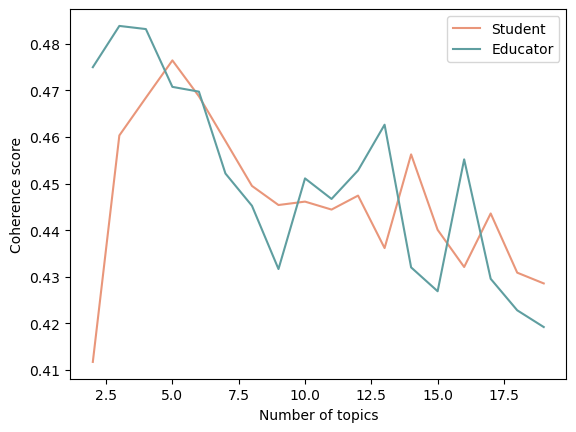

In [12]:
x = range(2, 20, 1)
plt.plot(x, coherence_values_student, color='darksalmon', label='Student')
plt.plot(x, coherence_values_teacher, color='cadetblue', label='Educator')
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.legend(['Student', 'Educator'], loc='best')
plt.show()

### 5.3 Training Model (Student)

#### 5.3.1 Word Frequency and Bigram Check

In [80]:
# Calculate word frequency
word_count = {}
for word in student_corpus_tokenized:
    for w in word:
        word_count[w] = word_count.get(w, 0) + 1
word_freq = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
print("Top 30 words:", word_freq[:30])

# Train the bigram model
bigram = Phrases(student_corpus_tokenized, min_count=3, threshold=10)  # Adjust threshold as needed
bigram_mod = Phraser(bigram)

# Apply the bigram model to the tokenized corpus
bigrams_in_corpus = [bigram_mod[doc] for doc in student_corpus_tokenized]

print("Biagrams", bigrams_in_corpus[:20])


Top 30 words: [('ai', 2761), ('student', 2756), ('work', 2187), ('write', 2072), ('school', 2018), ('professor', 1900), ('paper', 1654), ('take', 1436), ('one', 1315), ('time', 1273), ('say', 1242), ('think', 1194), ('good', 1184), ('college', 1177), ('also', 1108), ('people', 1105), ('chatgpt', 1003), ('way', 907), ('see', 889), ('writing', 868), ('give', 827), ('year', 798), ('help', 787), ('learn', 750), ('ask', 720), ('grade', 686), ('lot', 685), ('essay', 662), ('course', 640), ('find', 632)]
Biagrams [['idk', 'many', 'chatgpt', 'pretty_easy', 'spot', 'write', 'edit', 'human_writing', 'fast', 'good', 'ai', 'produce', 'derivative', 'word', 'salad', 'quickly', 'great', 'tool', 'organize_thought', 'essay', 'essay', 'c', 'student', 'work', 'good', 'think', 'real', 'issue', 'check', 'see', 'student', 'explain', 'complex', 'matter', 'word', 'essay', 'may', 'good', 'way', 'world', 'ai', 'work', 'bottom', 'half'], ['fear', 'genuine', 'work', 'confuse', 'ai', 'real', 'way', 'rebuke', 'prov

#### 5.3.2 LDA Model Training

In [76]:
# Train the LDA model
lda_model = LdaModel(corpus=doc_term_matrix_student, num_topics=5, d2word=dictionary_student, passes=10, random_state=100, update_every=1, chunksize=100, alpha='auto', per_word_topics=True)

# Print the topics found by the LDA model
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))

(0, '0.013"paper" + 0.010"chatgpt" + 0.010*"write" + 0.008*"take" + 0.007*"read" + 0.007*"plagiarism" + 0.006*"cheat" + 0.006*"assignment" + 0.005*"student" + 0.005*"say"')
(1, '0.047"ai" + 0.019"student" + 0.013*"paper" + 0.011*"work" + 0.009*"writing" + 0.007*"plagiarism" + 0.007*"chatgpt" + 0.006*"detection" + 0.006*"turnitin" + 0.005*"pay"')
(2, '0.022*"professor" + 0.021*"student" + 0.009*"people" + 0.008*"email" + 0.007*"grade" + 0.007*"work" + 0.007*"say" + 0.006*"department" + 0.005*"one" + 0.005*"take"')
(3, '0.036"school" + 0.017"college" + 0.015*"take" + 0.012*"people" + 0.011*"year" + 0.009*"student" + 0.009*"degree" + 0.008*"high" + 0.008*"course" + 0.007*"work"')
(4, '0.016"write" + 0.014"student" + 0.010*"help" + 0.010*"time" + 0.008*"good" + 0.008*"study" + 0.007*"school" + 0.006*"work" + 0.006*"take" + 0.005*"ai"')


#### 5.3.3 Get the Dominant Topic for Each Comment

In [26]:
# Initialize a dictionary for counting
topic_counts_student = defaultdict(int)
# Store the dominant topic and its probability for each document
document_topics_student = []

# Iterate through each document to get its topic distribution
for doc_bow in doc_term_matrix_student:
    # Get the list of topics for the document
    doc_topics_student = lda_model_5_student.get_document_topics(doc_bow)
    # Sort to find the most dominant topic
    doc_topics_student = sorted(doc_topics_student, key=lambda x: x[1], reverse=True)
    # Get the dominant topic and its proportion
    dominant_topic_student, prop_topic_student = doc_topics_student[0]
    # Count the occurrence of each dominant topic
    topic_counts_student[dominant_topic_student] += 1
    # Store the dominant topic and its proportion
    document_topics_student.append((dominant_topic_student, prop_topic_student))

# Calculate the total number of documents
total_documents_student = len(doc_term_matrix_student)
# Calculate the proportion of each topic
topic_proportions_student = {topic: count / total_documents_student for topic, count in topic_counts_student.items()}

# Print the count and proportion of documents per topic
print("Student Comments - Topic Document Counts:", topic_counts_student)
print("Student Comments - Topic Proportions:", topic_proportions_student)

# Optionally, print the dominant topic and its proportion for each document
# For example, print the topic and proportion for the first 10 documents
for doc_index in range(10):
    dominant_topic_student, prop_topic_student = document_topics_student[doc_index]
    print(f"Document {doc_index}: Dominant Topic {dominant_topic_student}, Proportion {prop_topic_student:.4f}")

Student Comments - Topic Document Counts: defaultdict(<class 'int'>, {1: 1853, 4: 1183, 2: 809, 3: 656, 0: 1061})
Student Comments - Topic Proportions: {1: 0.33315354189140595, 4: 0.2126932758000719, 2: 0.14545127651923767, 3: 0.11794318590435095, 0: 0.19075871988493348}
Document 0: Dominant Topic 1, Proportion 0.9625
Document 1: Dominant Topic 1, Proportion 0.9322
Document 2: Dominant Topic 4, Proportion 0.7952
Document 3: Dominant Topic 4, Proportion 0.9315
Document 4: Dominant Topic 2, Proportion 0.5176
Document 5: Dominant Topic 3, Proportion 0.5149
Document 6: Dominant Topic 3, Proportion 0.9095
Document 7: Dominant Topic 4, Proportion 0.7886
Document 8: Dominant Topic 3, Proportion 0.8971
Document 9: Dominant Topic 0, Proportion 0.5790


#### 5.3.4 Student's topic changing over time

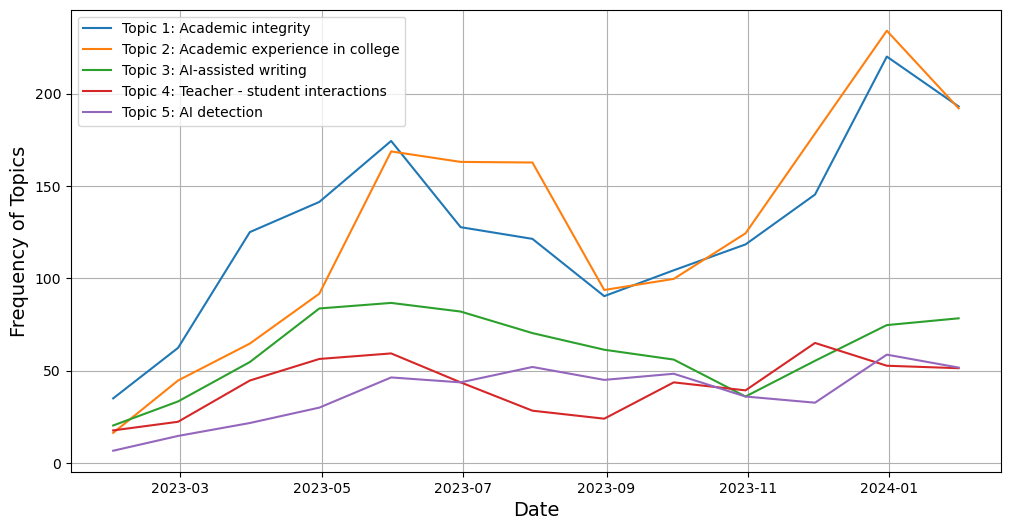

In [ ]:
# add a new column to the DataFrame to store the dominant topic for each comment
comment_student_df['Dominant Topic'] = [topic for topic, _ in document_topics_student]

# group by date and dominant topic
comment_student_df_groupedbymon = comment_student_df.groupby([pd.Grouper(key='Timestamp', freq='M'), 'Dominant Topic']).size().unstack(fill_value=0)

comment_student_df_groupedbymon_smoothed = comment_student_df_groupedbymon.rolling(window=3).mean()

topic_names = {
    0: 'Topic 1: Academic integrity',
    1: 'Topic 2: Academic experience in college',
    2: 'Topic 5: AI detection',  # Swap the label of topic 5 here
    3: 'Topic 4: Teacher - student interactions',
    4: 'Topic 3: AI-assisted writing'  # Swap the label of topic 3 here
}

# plot
plt.figure(figsize=(12, 6))

plot_order = [0, 1, 4, 3, 2]

for topic in plot_order:
    plt.plot(comment_student_df_groupedbymon_smoothed.index, comment_student_df_groupedbymon_smoothed[topic], label=topic_names[topic])

plt.xlabel('Date', fontsize=14)
plt.ylabel('Frequency of Topics', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


### 5.4 Training Model (Educator)

#### 5.4.1 Word Frequency and Biagrams

In [81]:
# Calculate word frequency
word_count = {}
for word in student_corpus_tokenized:
    for w in word:
        word_count[w] = word_count.get(w, 0) + 1
word_freq = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
print("Top 30 words:", word_freq[:30])

# Train the bigram model
bigram = Phrases(teacher_corpus_tokenized, min_count=3, threshold=10)
bigram_mod = Phraser(bigram)

# Apply the bigram model to the tokenized corpus
bigrams_in_corpus = [bigram_mod[doc] for doc in teacher_corpus_tokenized]

print("Biagrams", bigrams_in_corpus[:20])

Top 30 words: [('ai', 2761), ('student', 2756), ('work', 2187), ('write', 2072), ('school', 2018), ('professor', 1900), ('paper', 1654), ('take', 1436), ('one', 1315), ('time', 1273), ('say', 1242), ('think', 1194), ('good', 1184), ('college', 1177), ('also', 1108), ('people', 1105), ('chatgpt', 1003), ('way', 907), ('see', 889), ('writing', 868), ('give', 827), ('year', 798), ('help', 787), ('learn', 750), ('ask', 720), ('grade', 686), ('lot', 685), ('essay', 662), ('course', 640), ('find', 632)]
Biagrams [['show', 'work', 'write', 'course', 'similar', 'style_tone', 'level', 'grammatical', 'proficiency', 'fine', 'everything_else', 'write', 'sound', 'second', 'grader', 'final_paper', 'look', 'professionally', 'edit', 'ready', 'publication', 'issue'], ['ai', 'contest_grade', 'appropriate', 'channel', 'school', 'sometimes', 'ai_checker', 'wrong', 'fence', 'pretty', 'able_spot', 'ai_generate', 'work', 'without', 'checker', 'human', 'mistake', 'anything', 'wrong', 'sweat', 'let', 'process'

#### 5.4.2 LDA Model Training

In [27]:
# Train LDA model
lda_model_3_teacher = LdaMulticore(corpus=doc_term_matrix_teacher, id2word=dictionary_teacher, num_topics=3, 
                                 random_state=100, chunksize=1000, passes=10, workers=3)

# Print topics
topics_teacher = lda_model_3_teacher.print_topics(num_words=10)
for topic in topics_teacher:
    print(topic)

(0, '0.035*"student" + 0.008*"school" + 0.007*"time" + 0.007*"work" + 0.007*"think" + 0.007*"course" + 0.006*"teach" + 0.006*"take" + 0.006*"college" + 0.006*"one"')
(1, '0.027*"ai" + 0.023*"student" + 0.017*"write" + 0.016*"chatgpt" + 0.011*"paper" + 0.009*"writing" + 0.009*"work" + 0.007*"think" + 0.007*"assignment" + 0.006*"ask"')
(2, '0.038*"student" + 0.014*"grade" + 0.010*"one" + 0.008*"assignment" + 0.007*"work" + 0.007*"cheat" + 0.007*"say" + 0.007*"give" + 0.006*"course" + 0.006*"academic"')


#### 5.4.3 Get the Dominant Topic for Each Comment

In [28]:
# Initialize a dictionary
topic_counts_teacher = defaultdict(int)
# List to store the dominant topic and its proportion for each document
document_topics_teacher = []

# Iterate through each document to get its topic distribution
for doc_bow in doc_term_matrix_teacher:
    # Obtain topic distribution for the document
    doc_topics_teacher = lda_model_3_teacher.get_document_topics(doc_bow)
    # Sort topics by their proportion in descending order to find the dominant topic
    doc_topics_teacher = sorted(doc_topics_teacher, key=lambda x: x[1], reverse=True)
    # Extract the most dominant topic and its proportion
    dominant_topic_teacher, prop_topic_teacher = doc_topics_teacher[0]
    # Count how many times each topic is the dominant one
    topic_counts_teacher[dominant_topic_teacher] += 1
    # Store the dominant topic and its proportion
    document_topics_teacher.append((dominant_topic_teacher, prop_topic_teacher))

# Calculate the total number of documents
total_documents_teacher = len(doc_term_matrix_teacher)
# Calculate the proportion of each topic across all documents
topic_proportions_teacher = {topic: count / total_documents_teacher for topic, count in topic_counts_teacher.items()}

print("Teacher Comments - Topic Document Counts:", topic_counts_teacher)
print("Teacher Comments - Topic Proportions:", topic_proportions_teacher)


Teacher Comments - Topic Document Counts: defaultdict(<class 'int'>, {1: 4207, 2: 1850, 0: 2239})
Teacher Comments - Topic Proportions: {1: 0.5071118611378977, 2: 0.22299903567984572, 0: 0.2698891031822565}


#### 5.4.4 Educator's topics changing over time

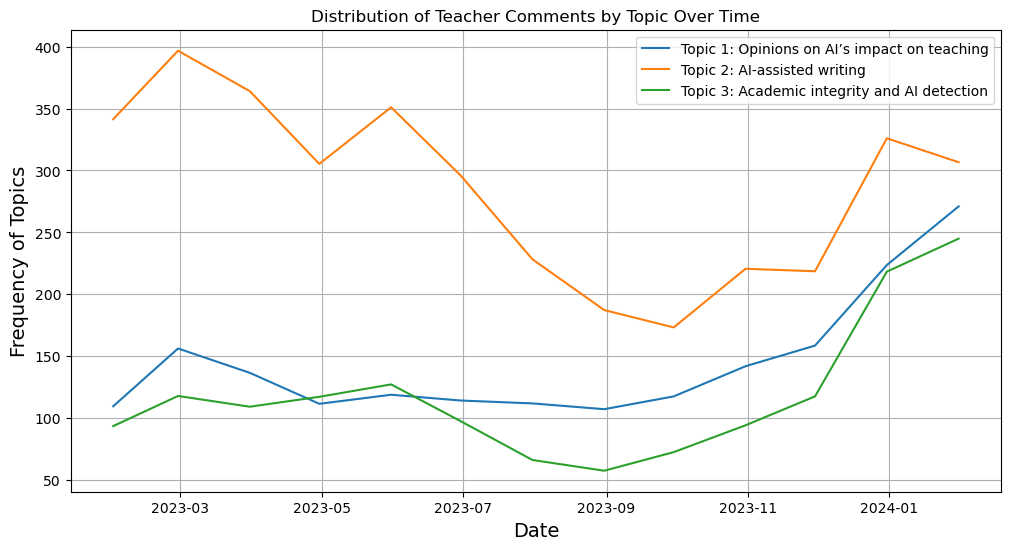

In [43]:
# Convert 'Timestamp' to datetime
comment_teacher_df.loc[:, 'Timestamp'] = pd.to_datetime(comment_teacher_df['Timestamp'])

# Add a new column to store the dominant topic for each comment
comment_teacher_df.loc[:, 'Dominant Topic'] = [topic for topic, _ in document_topics_teacher]

# Group by date and dominant topic
comment_teacher_df_groupedbymon = comment_teacher_df.groupby([pd.Grouper(key='Timestamp', freq='M'), 'Dominant Topic']).size().unstack(fill_value=0)

# Calculate the rolling mean
comment_teacher_df_groupedbymon_smoothed = comment_teacher_df_groupedbymon.rolling(window=3).mean()

# Define topic names
topic_names = {
    0: 'Topic 1: Opinions on AI’s impact on teaching',
    1: 'Topic 2: AI-assisted writing',
    2: 'Topic 3: Academic integrity and AI detection'
}

# Plotting
plt.figure(figsize=(12, 6))
for topic in topic_names.keys():
    plt.plot(comment_teacher_df_groupedbymon_smoothed.index, comment_teacher_df_groupedbymon_smoothed[topic], label=topic_names[topic])

plt.xlabel('Date', fontsize=14)
plt.ylabel('Frequency of Topics', fontsize=14)
plt.title('Distribution of Teacher Comments by Topic Over Time')
plt.legend()
plt.grid(True)
plt.show()


# 6. Sentiment Analysis - SentiStrength

### 6.1 Conduct Sentiment Analysis

In [47]:
def preprocess_comments(df, column_name='Comment Body'):
    """Preprocess comments and save to a text file. Ensure each comment is not split due to newlines."""
    # Replace all forms of newline characters
    comments = df[column_name].fillna('').apply(lambda x: x.replace('\r\n', ' ').replace('\n', ' ').replace('\r', ' '))
    comments = comments[comments != '']  # Remove empty comments
    output_file_path = 'sample_input.txt'
    with open(output_file_path, 'w', encoding='utf-8') as file:
        for comment in comments:
            file.write(comment + '\n')
    return output_file_path

def analyze_sentiment_senti_strength(input_file_path):
    """Invoke SentiStrength to analyze comments in a text file."""
    command = f"java -jar SentiStrengthCom.jar sentidata SentiStrengthDataEnglishOctober2019/ input {input_file_path}"
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    stdout, stderr = process.communicate()
    output = stdout.decode('utf-8')
    return output

def read_sentiment_scores(output_file_path):
    """Read sentiment scores from the specified output file."""
    sentiment_scores = []
    with open(output_file_path, 'r', encoding='utf-8') as file:
        next(file)  # Skip the header line
        for line in file:
            parts = line.strip().split()
            scores = [part for part in parts if part.replace('-', '').isdigit()]
            if len(scores) >= 2:
                # Only take the first two numbers as sentiment scores
                pos_score, neg_score = scores[:2]
                try:
                    pos_score, neg_score = int(pos_score), int(neg_score)
                    sentiment_scores.append((pos_score, neg_score))
                except ValueError:
                    print(f"Could not convert scores to integers: {scores}")
            else:
                print(f"Unexpected format or missing scores in line: {line}")
    return sentiment_scores

In [48]:
# apply the functions to student dataset
input_file_path_student = preprocess_comments(comment_student_df, 'Comment Body')
analyze_sentiment_senti_strength(input_file_path_student)

'Finished! Results in: sample_input7_out.txt\r\n'

In [49]:
# apply the functions to teacher dataset
input_file_path_teacher = preprocess_comments(comment_teacher_df, 'Comment Body')
analyze_sentiment_senti_strength(input_file_path_teacher)

'Finished! Results in: sample_input8_out.txt\r\n'

### 6.2 Sentiment Analysis Results

Student's Sentiment Scores

In [50]:
# Reading student's sentiment score input text
output_file_path_student = 'sample_input2_out.txt'

sentiment_scores_student = read_sentiment_scores(output_file_path_student)

# check if the number of comments is correct
if len(sentiment_scores_student) == len(comment_student_df):
    comment_student_df['positive_strength'], comment_student_df['negative_strength'] = zip(*sentiment_scores_student)
else:
    print("Warning: The number of sentiment scores does not match the number of rows in the DataFrame.")

print(len(comment_student_df))
print(len(sentiment_scores_student))

comment_student_df

5562
5562


,Subreddit,Post ID,Comment ID,Comment Body,Timestamp,Votes,is_relevant,Dominant Topic,positive_strength,negative_strength
0,college,10jjnva,j5li9vh,"IDK how many of you have tried ChatGPT, but it...",2023-01-23 22:20:08,550,True,1,3,-1
1,college,10jjnva,j5mglcn,My fear about this is that studentâs genuine...,2023-01-24 02:13:52,174,True,1,2,-4
2,college,10jjnva,j5m9su6,This just further reinforces that we are going...,2023-01-24 01:24:28,145,True,4,1,-4
5,college,10jjnva,j5n6r77,It seems kinda sad to me that students at what...,2023-01-24 05:35:35,19,True,4,1,-4
6,college,10jjnva,j5oqt94,>In a message to the public computer science (...,2023-01-24 15:51:47,7,True,2,3,-1
...,...,...,...,...,...,...,...,...,...,...
26961,CollegeRant,129wk04,jetiqtz,Who determines which circumstances are worthy ...,2023-04-03 20:48:28,2,True,2,1,-3
26963,CollegeRant,129wk04,jeu8vga,I meant lab tests in the sense of a lab test w...,2023-04-03 23:39:54,4,True,0,1,-1
26964,CollegeRant,129wk04,jev6zk3,i have attendance accommodations too! due to a...,2023-04-04 03:47:22,3,True,2,2,-2
26967,CollegeRant,129wk04,jjaggmj,I have the same accommodation for chronic pain...,2023-05-08 04:40:00,2,True,2,2,-5


Educator's Sentiment Scores

In [51]:
# Reading educator's sentiment score input text
output_file_path_teacher = 'sample_input1_out.txt'

sentiment_scores_teacher = read_sentiment_scores(output_file_path_teacher)

# check if the number of comments is correct
if len(sentiment_scores_teacher) == len(comment_teacher_df):
    comment_teacher_df.loc[:, 'positive_strength'], comment_teacher_df.loc[:, 'negative_strength'] = zip(*sentiment_scores_teacher)
else:
    print("Warning: The number of sentiment scores does not match the number of rows in the DataFrame.")

print(len(comment_teacher_df))
print(len(sentiment_scores_teacher))

comment_teacher_df

8296
8296


C:\Users\63195\AppData\Local\Temp\ipykernel_241128\3922171834.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_teacher_df.loc[:, 'positive_strength'], comment_teacher_df.loc[:, 'negative_strength'] = zip(*sentiment_scores_teacher)
C:\Users\63195\AppData\Local\Temp\ipykernel_241128\3922171834.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_teacher_df.loc[:, 'positive_strength'], comment_teacher_df.loc[:, 'negative_strength'] = zip(*sentiment_scores_teacher)


,Subreddit,Post ID,Comment ID,Comment Body,Timestamp,Votes,is_relevant,Dominant Topic,positive_strength,negative_strength
2,AskProfessors,18vniv3,kfugp2q,If you can show other work written for the cou...,2024-01-01 17:14:11,33,True,1,3,-1
3,AskProfessors,18vniv3,kftwfyc,If you didnât use AI then contest your grade...,2024-01-01 14:31:09,108,True,1,3,-2
4,AskProfessors,18vniv3,kfuhol4,Just Google your school name and the words â...,2024-01-01 17:20:48,9,True,2,1,-1
5,AskProfessors,18vniv3,kftzwfk,Contest your grade. File a grievance. Go to ...,2024-01-01 15:04:02,28,True,2,2,-4
8,AskProfessors,18vniv3,kfvruz0,This is a bummer. Please know that this stuff ...,2024-01-01 22:00:32,3,True,2,3,-3
...,...,...,...,...,...,...,...,...,...,...
39434,Professors,157oi39,jt65a5v,I worried about that when I first did the quiz...,2023-07-23 23:20:03,0,True,0,3,-4
39435,Professors,157oi39,jt64alk,I had students in the US and China during the ...,2023-07-23 23:12:57,2,True,2,1,-1
39436,Professors,157oi39,jt7gdlo,"I read that, but thatâs a pretty big obstacl...",2023-07-24 05:39:07,-3,True,0,3,-2
39438,Professors,157oi39,jt64ipq,And no one complained about the time limited q...,2023-07-23 23:14:34,1,True,0,1,-2


### 6.3 Sentiment Visualization

Add a new column to DataFrame to present sentiment scores and distribution.

In [52]:
# Define the neutral range
neutral_range = (-0.5, 0.5)

# Calculate the sentiment label
comment_student_df['Sentiment'] = comment_student_df.apply(
    lambda row: 0 if neutral_range[0] <= (row['positive_strength'] + row['negative_strength']) <= neutral_range[1]
    else 1 if row['positive_strength'] > abs(row['negative_strength'])
    else -1,
    axis=1
)

comment_teacher_df['Sentiment'] = comment_teacher_df.apply(
    lambda row: 0 if neutral_range[0] <= (row['positive_strength'] + row['negative_strength']) <= neutral_range[1]
    else 1 if row['positive_strength'] > abs(row['negative_strength'])
    else -1,
    axis=1
)

# Display the results
pd.value_counts(comment_student_df['Sentiment'])/len(comment_student_df)


C:\Users\63195\AppData\Local\Temp\ipykernel_241128\274527557.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_teacher_df['Sentiment'] = comment_teacher_df.apply(


Sentiment
-1    0.40525
 0    0.31913
 1    0.27562
Name: count, dtype: float64

#### 6.3.1 Sentiment trends over time (weekly trend)

Student

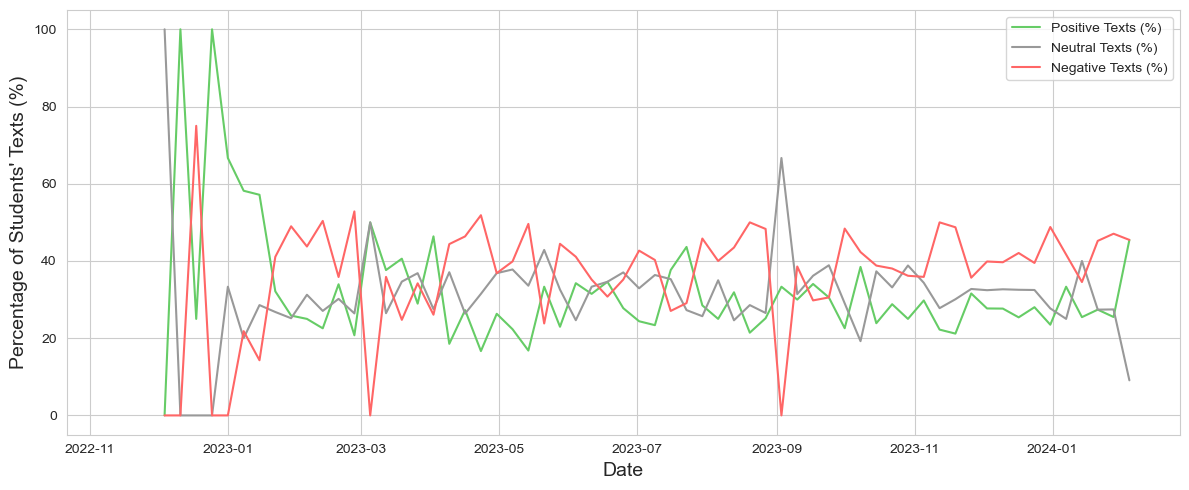

In [246]:
# Calculate the total number of comments per week
stu_weekly_counts_total = comment_student_df.resample('W').size()

# Count the weekly number of positive and negative comments separately
stu_positive_counts = comment_student_df[comment_student_df['Sentiment'] == 1].resample('W').size()
stu_neutral_counts = comment_student_df[comment_student_df['Sentiment'] == 0].resample('W').size()
stu_negative_counts = comment_student_df[comment_student_df['Sentiment'] == -1].resample('W').size()

# Calculate the weekly percentage of positive and negative reviews
stu_positive_percentage = (stu_positive_counts / stu_weekly_counts_total) * 100
stu_neutral_percentage = (stu_neutral_counts / stu_weekly_counts_total) * 100
stu_negative_percentage = (stu_negative_counts / stu_weekly_counts_total) * 100

# plot
plt.figure(figsize=(12, 5))
plt.plot(stu_positive_percentage.index, stu_positive_percentage.values, label='Positive Texts (%)', color='#66cc66')
plt.plot(stu_neutral_percentage.index, stu_neutral_percentage.values, label='Neutral Texts (%)', color='#999999')
plt.plot(stu_negative_percentage.index, stu_negative_percentage.values, label='Negative Texts (%)', color='#ff6666')
plt.xlabel('Date', fontsize=14)
plt.ylabel("Percentage of Students' Texts (%)", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Educator

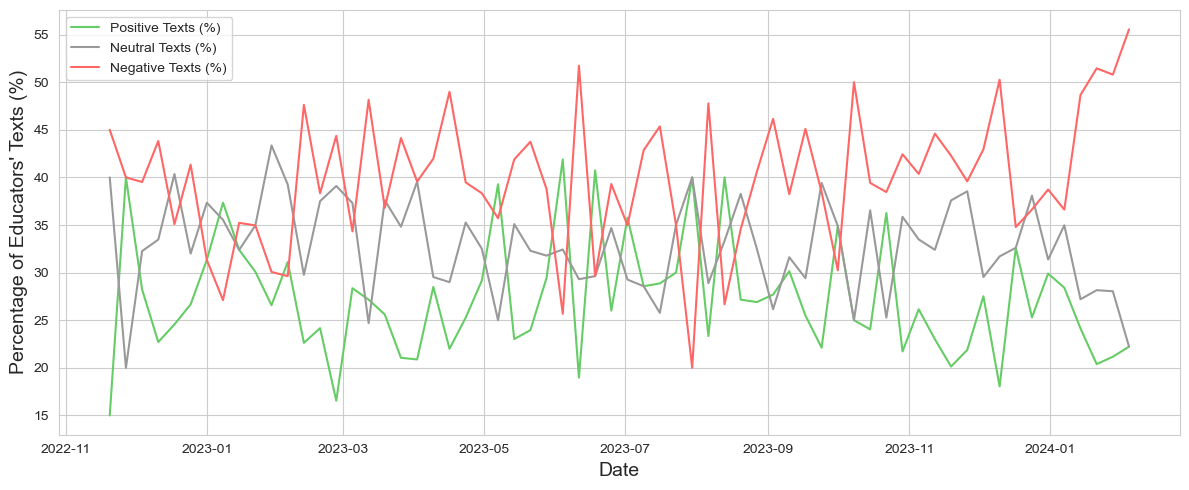

In [247]:
tea_weekly_counts_total = comment_teacher_df.resample('W').size()

tea_positive_counts = comment_teacher_df[comment_teacher_df['Sentiment'] == 1].resample('W').size()
tea_neutral_counts = comment_teacher_df[comment_teacher_df['Sentiment'] == 0].resample('W').size()
tea_negative_counts = comment_teacher_df[comment_teacher_df['Sentiment'] == -1].resample('W').size()

tea_positive_percentage = (tea_positive_counts / tea_weekly_counts_total) * 100
tea_neutral_percentage = (tea_neutral_counts / tea_weekly_counts_total) * 100
tea_negative_percentage = (tea_negative_counts / tea_weekly_counts_total) * 100

plt.figure(figsize=(12, 5))
plt.plot(tea_positive_percentage.index, tea_positive_percentage.values, label='Positive Texts (%)', color='#66cc66')
plt.plot(tea_neutral_percentage.index, tea_neutral_percentage.values, label='Neutral Texts (%)', color='#999999')
plt.plot(tea_negative_percentage.index, tea_negative_percentage.values, label='Negative Texts (%)', color='#ff6666')
plt.xlabel('Date', fontsize=14)
plt.ylabel("Percentage of Educators' Texts (%)", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 6.3.2 Emotions vary with topics

In [83]:
comment_student_df.groupby('Dominant Topic')['Sentiment'].mean()

Dominant Topic
0    0.000943
1   -0.219644
2   -0.341162
3   -0.050305
4   -0.005072
Name: Sentiment, dtype: float64

ANOVA Test to compare difference in sentiment polarities of different topics.

In [84]:
def perform_anova(dataframe, nominal_var, continuous_var):
    # Group the continuous variable by the nominal variable
    groups = [group[continuous_var].values for name, group in dataframe.groupby(nominal_var)]
    
    # Perform the ANOVA test
    f_statistic, p_value = f_oneway(*groups)
    
    return f_statistic, p_value

f_stat_stu, p_val_stu = perform_anova(comment_student_df, 'Dominant Topic', 'Sentiment')
print(f"F-statistic: {f_stat_stu}, P-value: {p_val_stu}")

f_stat_tea, p_val_tea = perform_anova(comment_teacher_df, 'Dominant Topic', 'Sentiment')
print(f"F-statistic: {f_stat_tea}, P-value: {p_val_tea}")

F-statistic: 35.40253984038556, P-value: 3.0227425705417833e-29
F-statistic: 105.42192569607124, P-value: 6.1400844067278546e-46


Students’ Sentiment Distribution by Dominant Topic.

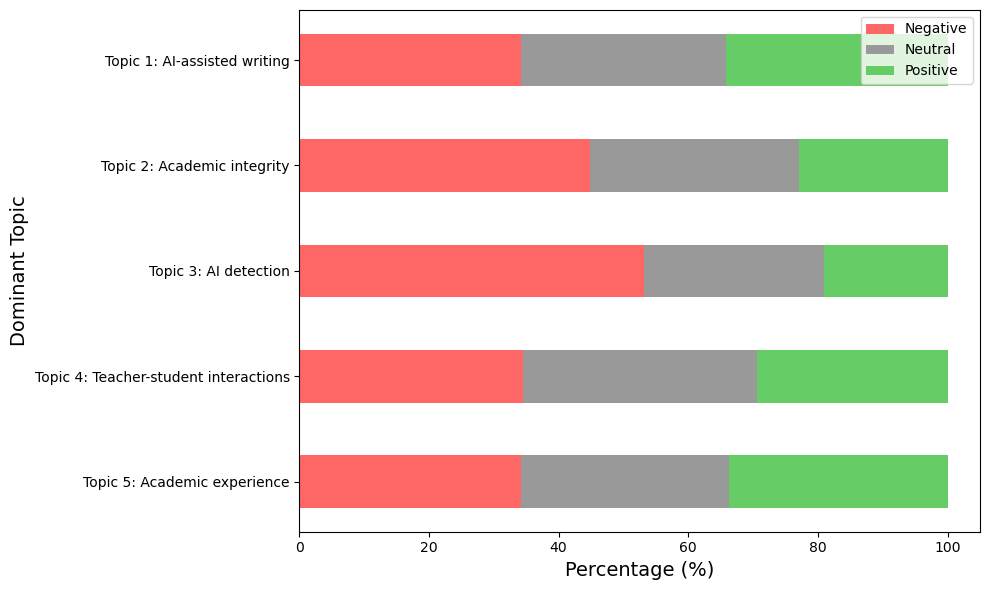

In [94]:
# Calculate the count of sentiments for each topic using a cross-tabulation
topic_sentiment_count = pd.crosstab(comment_student_df['Dominant Topic'], comment_student_df['Sentiment'])

# Convert the counts into percentages
topic_sentiment_percentage = topic_sentiment_count.div(topic_sentiment_count.sum(axis=1), axis=0) * 100

# Reorder the topics, ensuring topic numbering starts from 1
topic_sentiment_percentage.index = range(1, len(topic_sentiment_percentage) + 1)

# Define a mapping of topic indices to topic names
topic_names = {
    1: 'Topic 1: AI-assisted writing',
    2: 'Topic 2: Academic integrity',
    3: 'Topic 3: AI detection',
    4: 'Topic 4: Teacher-student interactions',
    5: 'Topic 5: Academic experience'
}

# Update the index of the DataFrame using the topic name mapping
topic_sentiment_percentage.rename(index=topic_names, inplace=True)

# Reverse the DataFrame to display topics from 1 to 5 top to bottom
topic_sentiment_percentage = topic_sentiment_percentage.iloc[::-1]

# Plot a stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Initialize a cumulative array to use for positioning stacked bars
cumulative = np.zeros(len(topic_sentiment_percentage))

# Define colors and labels corresponding to sentiments
colors = {-1: '#ff6666', 0: '#999999', 1: '#66cc66'}
sentiment_labels = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
bar_height = 0.5

# Plot bars for each sentiment category
for sentiment_value in [-1, 0, 1]:
    values = topic_sentiment_percentage[sentiment_value]
    ax.barh(topic_sentiment_percentage.index, values, color=colors[sentiment_value], left=cumulative, label=sentiment_labels[sentiment_value], height=bar_height)   
    cumulative += values

# Add chart title and axis labels
ax.set_xlabel('Percentage (%)', fontsize=14)
ax.set_ylabel('Dominant Topic', fontsize=14)

# Add a legend to the chart
ax.legend()

# Display the chart with an optimized layout
plt.tight_layout()
plt.show()


Educators’ Sentiment Distribution by Dominant Topic.



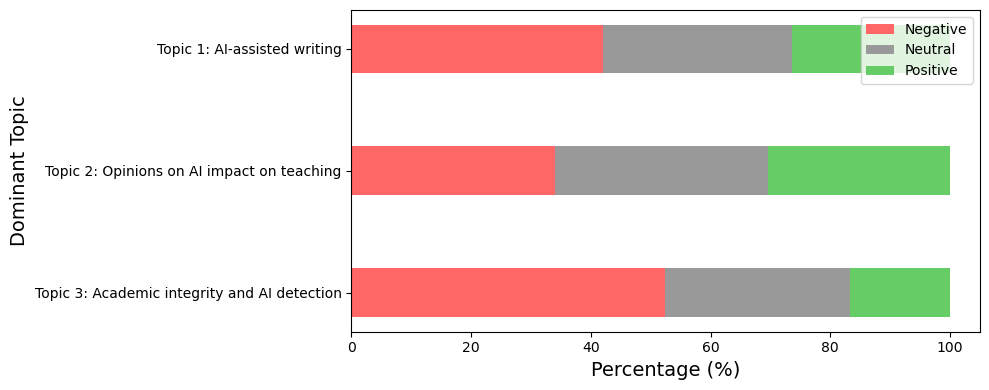

In [95]:
# Calculate the count of sentiments for each topic using a cross-tabulation
topic_sentiment_count = pd.crosstab(comment_teacher_df['Dominant Topic'], comment_teacher_df['Sentiment'])

# Convert the counts to percentages
topic_sentiment_percentage = topic_sentiment_count.div(topic_sentiment_count.sum(axis=1), axis=0) * 100

# Reorder the topics, ensuring the topic numbering starts from 1
topic_sentiment_percentage.index = range(1, len(topic_sentiment_percentage) + 1)

# Define a mapping of topic indices to topic names
topic_names = {
    1: 'Topic 1: AI-assisted writing',
    2: 'Topic 2: Opinions on AI impact on teaching',
    3: 'Topic 3: Academic integrity and AI detection',
}

# Update the DataFrame index to use the defined topic names
topic_sentiment_percentage.rename(index=topic_names, inplace=True)

# Reverse the DataFrame to display topics from bottom to top in the specified order
topic_sentiment_percentage = topic_sentiment_percentage.iloc[::-1]

# Plot a stacked bar chart
fig, ax = plt.subplots(figsize=(10, 4))

# Initialize a cumulative array to use for positioning the stacked bars
cumulative = np.zeros(len(topic_sentiment_percentage))

# Define colors and labels corresponding to sentiments
colors = {-1: '#ff6666', 0: '#999999', 1: '#66cc66'}
sentiment_labels = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
bar_height = 0.4

# Plot bars for each sentiment category
for sentiment_value in [-1, 0, 1]:
    values = topic_sentiment_percentage[sentiment_value]
    ax.barh(topic_sentiment_percentage.index, values, color=colors[sentiment_value], left=cumulative, label=sentiment_labels[sentiment_value], height=bar_height)
    cumulative += values

# Add chart title and axis labels
ax.set_xlabel('Percentage (%)', fontsize=14)
ax.set_ylabel('Dominant Topic', fontsize=14)

# Add a legend to the chart
ax.legend()

# Optimize layout and display the chart
plt.tight_layout()
plt.show()

In [96]:
comment_teacher_df.groupby('Dominant Topic')['Sentiment'].mean()

Dominant Topic
0   -0.155427
1   -0.036130
2   -0.356757
Name: Sentiment, dtype: float64